In [26]:
import os 
from dotenv import load_dotenv
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [27]:
groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

In [28]:
@tool 
def addition(a: int, b: int):
    """This function will add the two numbers"""
    return a + b 

In [29]:
@tool 
def multiply(a: int, b: int) -> int:
    """This function is to multiply two numbers"""
    return a*b

In [30]:
search = TavilySearchResults()

In [31]:
tools = [addition, multiply, search]

In [32]:
llm_with_tool = llm.bind_tools(tools)

In [33]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with using arithmetic and search inputs")

In [34]:
def call_modal(state: MessagesState):
    return {"messages": [llm_with_tool.invoke([sys_msg] + state['messages'])]}

In [35]:
workflow = StateGraph(MessagesState)

workflow.add_node("reasoner", call_modal)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    tools_condition
)
workflow.add_edge("tools", "reasoner")

app = workflow.compile()

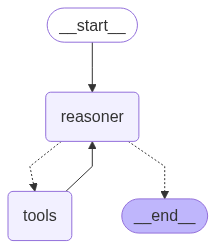

In [36]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
from langchain_core.messages import HumanMessage

app.invoke({"messages": [HumanMessage(content = "what is the elon musk age double")]})

# app.invoke({"messages": [("user", "what is the elon musk age double")]})

{'messages': [HumanMessage(content='what is the elon musk age double', additional_kwargs={}, response_metadata={}, id='10ef394a-e913-4420-9039-cee06c7a7f06'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_39b0', 'function': {'arguments': '{"a":50,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 419, 'total_tokens': 438, 'completion_time': 0.091673252, 'prompt_time': 0.026782445, 'queue_time': 0.05319658399999999, 'total_time': 0.118455697}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bc165f8d-d54a-4eb3-b41b-d31053a852d8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 50, 'b': 2}, 'id': 'call_39b0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 419, 'output_tokens': 19, 'total_tokens': 438}),
  ToolMessage(content='100', name='multiply', id='887767e1-e60a-428d-8169-576270dc26bc

In [38]:
inputs = {"messages": ["what is the Narendra Modi's age with addition of 5"]}

for events in app.stream(inputs):
    for key, value in events.items():
        print(f"Node name: {key}")
        print(value)
        print("========")

Node name: reasoner
{'messages': [AIMessage(content='<function=addition{"a": 72, "b": 5}</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 422, 'total_tokens': 441, 'completion_time': 0.084073691, 'prompt_time': 0.028138349, 'queue_time': 0.075154371, 'total_time': 0.11221204}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--bd5f2f4d-7a1e-4b53-ab77-8bf3db14afb4-0', usage_metadata={'input_tokens': 422, 'output_tokens': 19, 'total_tokens': 441})]}


#########################

In [39]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages, BaseMessage

In [40]:
class GraphState(TypedDict):
    query: str 
    finance: str 
    final_answer: str 
    messages: Annotated[list[BaseMessage], add_messages]

In [41]:
import yfinance as yf

def get_stock_price(ticker: str):
    """Get the stock price from Yahoo Finance"""
    stock = yf.Ticker(ticker)
    return stock.info['PreviousClose']

In [42]:
tools = [addition, multiply, search, get_stock_price]

llm_with_tool = llm.bind_tools(tools)

In [43]:
def reasoner(state: GraphState):
    messages = state['messages']
    query = state['query']
    print(query)
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, yahoo finance and arithmetic tools")
    return {"messages": [llm_with_tool.invoke([sys_msg] + query)]}

In [44]:
workflow = StateGraph(GraphState)

workflow.add_node("reasoner", call_modal)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    tools_condition
)
workflow.add_edge("tools", "reasoner")

app = workflow.compile()

In [45]:
app.invoke({"query": ["What is the stock price of Apple add 1000?"]})

{'query': ['What is the stock price of Apple add 1000?'],
 'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_81mg', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'addition'}, 'type': 'function'}, {'id': 'call_y8g0', 'function': {'arguments': '{"a":2,"b":7}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 460, 'total_tokens': 497, 'completion_time': 0.134545455, 'prompt_time': 0.029051808, 'queue_time': 0.053974612000000005, 'total_time': 0.163597263}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--76e828b1-3694-4d1a-8c46-990019bdca2c-0', tool_calls=[{'name': 'addition', 'args': {'a': 5, 'b': 3}, 'id': 'call_81mg', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 2, 'b': 7}, 'id': 'call_y8g0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 460, 'output_tokens': 37, 'total

In [46]:
inputs = {"query": ["What is the stock price of Apple add 1000?"]}

for events in app.stream(inputs):
    for key, value in events.items():
        print(f"Node name: {key}")
        print(value)
        print("===")

Node name: reasoner
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fvsm', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'addition'}, 'type': 'function'}, {'id': 'call_gmf1', 'function': {'arguments': '{"a":2,"b":7}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 460, 'total_tokens': 497, 'completion_time': 0.134545455, 'prompt_time': 0.038798854, 'queue_time': 0.052903206, 'total_time': 0.173344309}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--464c7d84-74bd-496d-b650-2200392e64d3-0', tool_calls=[{'name': 'addition', 'args': {'a': 5, 'b': 3}, 'id': 'call_fvsm', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 2, 'b': 7}, 'id': 'call_gmf1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 460, 'output_tokens': 37, 'total_tokens': 497})]}
===
Node name: tools
{'messag

In [47]:
response = app.invoke({"query": ["What is the stock price of Apple add 1000?"]})

In [48]:
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  addition (call_3mvy)
 Call ID: call_3mvy
  Args:
    a: 5
    b: 3
  multiply (call_wemy)
 Call ID: call_wemy
  Args:
    a: 2
    b: 7
================================= Tool Message =================================
Name: addition

8
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_se5m)
 Call ID: call_se5m
  Args:
    query: latest news on stock market trends
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://finance.yahoo.com/topic/stock-market-news/", "content": "The Dow Jones Industrial Average added 0.2%, and the Nasdaq composite rose 0.6%. The hope is that President Donald Trump will lower his tariffs on China and other countries